<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Обучение-и-тестирование" data-toc-modified-id="Обучение-и-тестирование-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и тестирование</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Разделяем-выборки" data-toc-modified-id="Разделяем-выборки-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Разделяем выборки</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Градиентный бустинг</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm

In [3]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
df.sort_index(inplace=True)

In [5]:
df.head(10)

In [6]:
df.info()

Процент пропущенных значений в каждом столбце.

In [7]:
df.isna().mean() * 100

In [8]:
df.describe()

Выполним ресемплинг

In [9]:
df = df.resample('1H').sum()
df.head()

Посмотрим на данные

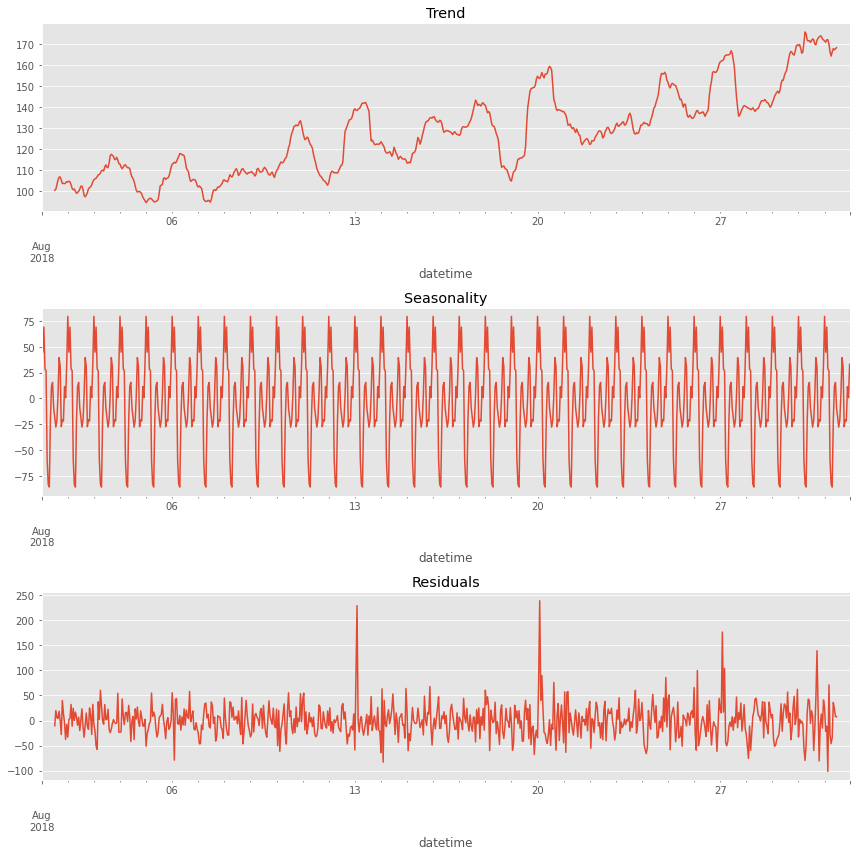

In [10]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(df['2018-08':'2018-08'])
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Residuals')
plt.tight_layout()

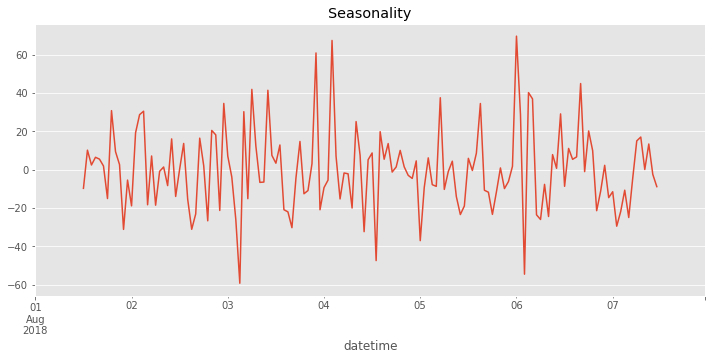

In [11]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(df['2018-08-01':'2018-08-07'])
plt.figure(figsize=(12, 5))
decomposed.resid.plot(ax=plt.gca())
plt.title('Seasonality')

### Выводы

- Данные загружены
- Проведено семплирование данных
- Построены графики тренда и сезонной составляющей
- Распределение сезонной части выглядит статическим в интервале суток. Ночью такси почти не заказывают, пик ближе к вечеру
- Трэнд показывает линейный рост количества заказов со временем

## Обучение и тестирование

### Создание признаков

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek    
    data['day'] = data.index.day
    
    for i in range(1, max_lag + 1):
        data[f'lag_{i}'] = data['num_orders'].shift(i)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    
    return data

In [13]:
df = make_features(df, 20, 30)

In [14]:
df.head()

### Разделяем выборки

In [15]:
X = df.drop('num_orders', axis=1)
y = df['num_orders']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=False,    
    random_state=12345
)

In [17]:
X_train.shape

In [18]:
y_train.shape

In [19]:
X_test.shape

In [20]:
y_test.shape

### Линейная регрессия

In [21]:
tscv = TimeSeriesSplit(n_splits=8)

In [22]:
parameters = {
    'fit_intercept':[True,False],
    'copy_X':[True, False]
}

grid_model_line = GridSearchCV(LinearRegression(), parameters, cv=tscv)

grid_model_line.fit(X_train, y_train)

params_line = grid_model_line.best_params_

model_line = LinearRegression(**params_line)

model_line.fit(X_train, y_train)

predictions_line = model_line.predict(X_test)

print(params_line)

print("RMSE модели линейной регрессии на тестовой выборке: ", round(mean_squared_error(y_test, predictions_line) ** 0.5, 2))

### Градиентный бустинг

In [23]:
param_model = {
    'n_estimators': [1000], 
    'learning_rate': [0.015, 0.02, 0.035, 0.15],
    'max_depth': [8, 10, 12, 14],
    'num_leaves': [6, 12, 25, 50]
}

<div class="alert alert-block alert-info">

<b>Примечание: </b> Ячейку ниже можно раcкоментировать, но она достаточно долго обрабатывается. Полученные параметры сохранены в следующей ячейке. 
</div>

In [24]:
# lgbm = lightgbm.LGBMRegressor(random_state=12345)

# grid_model_LGBM = GridSearchCV(
#     estimator=lgbm,
#     param_grid=param_model,    
#     cv=tscv,
#     n_jobs=-1,
#     scoring='neg_root_mean_squared_error'
# )

# grid_model_LGBM.fit(X_train, y_train)

# best_params_LGBM = grid_model_LGBM.best_params_

# print(best_params_LGBM)

In [25]:
best_params_LGBM = {'learning_rate': 0.02, 'max_depth': 14, 'n_estimators': 1000, 'num_leaves': 50}

In [26]:
model_LGBM = lightgbm.LGBMRegressor(**best_params_LGBM, random_state=12345)

model_LGBM.fit(X_train, y_train)

predictions_LGBM = model_LGBM.predict(X_test)

print("RMSE модели LightGBM на тестовой выборке: ", round(mean_squared_error(y_test, predictions_LGBM) ** 0.5, 2))

In [27]:
test_pred = pd.DataFrame({ 
    'y_test' : y_test,
    'y_pred_LinearRegression' : predictions_line,
    'y_pred_LGBM' : predictions_LGBM
    })

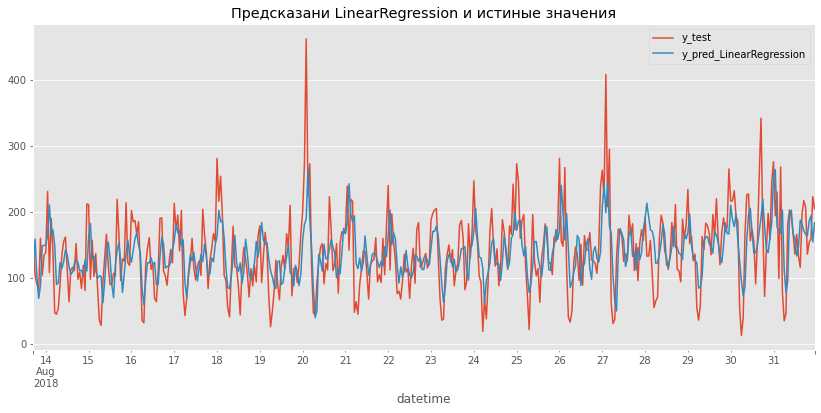

In [28]:
test_pred[['y_test', 'y_pred_LinearRegression']].plot(figsize=(14,6), title='Предсказани LinearRegression и истиные значения');

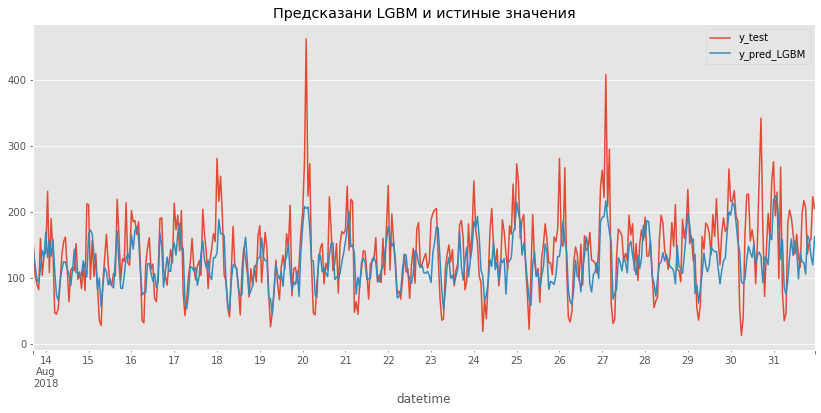

In [29]:
test_pred[['y_test', 'y_pred_LGBM']].plot(figsize=(14,6), title='Предсказани LGBM и истиные значения');

## Выводы

- Данные загружены. Проведено ресемплирование данных.
- Созданы признаки и обучены модели линейной регресии и LightGBM.
- Рассчитана метрика RMSE для моделей.
- Лучшее значение RMSE на тестовой выборке у модели LightGBM: 47.35
- На графиках визуально лучше предсказывает модель LinearRegression